In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import nibabel as nb
from scipy.stats import spearmanr, pearsonr
import seaborn as sns
from sklearn.linear_model import LinearRegression
from matplotlib import cm
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import os
import pandas as pd

/home/users/kwagstyl/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/users/kwagstyl/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/users/kwagstyl/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/users/kwagstyl/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/users/kwagstyl/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: Runti

In [2]:
rootdir='/data1/users/kwagstyl/bigbrain/Hierarchy/'
geodesicdir='/data1/users/kwagstyl/bigbrain/Hierarchy/geodesics/'
figdir='/data1/users/kwagstyl/bigbrain/NeuralNetworks/figs/'
surfdir='/data1/users/kwagstyl/bigbrain/NeuralNetworks/surfdir/'

In [3]:
def beta_confidence_interval(y,x):
    """carry out OLS stats test returning:
    B and the 95% confidence interval"""
    x2=sm.add_constant(x.copy())
    model = sm.OLS(y, x2)
    res = model.fit()
    ci=res.conf_int(alpha=0.05, cols=None)

    return res.params[1], ci[1,0], ci[1,1]


def plot_kde_hemis(r_thick, r_dist,l_thick, l_dist, system):
    """plot kernal density with scatter and marginal plots from seaborn"""
    ax = sns.kdeplot(r_thick, r_dist,
                 cmap="Reds", shade=True, shade_lowest=False,alpha=0.5)
    ax = sns.kdeplot(l_thick, l_dist,
                 cmap="Blues", shade=True, shade_lowest=False,alpha=0.5)
    ax = sns.regplot(r_thick, r_dist,lowess=True,scatter=False,color="Red")
    ax = sns.regplot(l_thick, l_dist,lowess=True,scatter=False,color="Blue")
    r_corr,r_p = pearsonr(r_thick, r_dist)
    l_corr,l_p = pearsonr(l_thick, l_dist)
    ax.set(xlabel="Geodesic distance \nfrom primary "+system+" area (mm)",
                 ylabel="Cortical thickness (mm)")
    ax.set(yticks=[1.0,2.0,3.0],yticklabels=['1.0','2.0','3.0'])
    ax.legend(['right, R='+str(np.round(r_corr,decimals=2))+', p='+str(np.round(r_p,decimals=2)),
               'left, R='+str(np.round(l_corr,decimals=2))+', p='+str(np.round(l_p,decimals=2))])
    return ax

def plot_kde(y,x,regions, cmap="magma"):
    """plot kernal density with scatter and marginal plots from seaborn"""
    g=sns.jointplot(x[regions],y[regions],color=cm.magma(80),cmap=cmap,shade=True, shade_lowest=False,alpha=0.9,kind='kde')
    g.plot_joint(plt.scatter, c=cm.magma(50), s=10, linewidth=0, marker=".",alpha=0.1)
    g.set_axis_labels("Geodesic distance mm", "Cortical thickness (mm)");
    g.plot_joint(sns.regplot,ci=0.95,scatter=False,color=cm.magma(80),lowess=True)
    return g

def plot_gradients(Thickness,distances,regions):
    """plot gradients with c.i.s
    input geodesic distances, layer thicknesses, region to include."""
    beta=np.zeros((6,3))
    for i in range(6):
        y=Thickness["layer{0}".format(i+1)][regions]
        x=distances[regions]
        #g=plot_kde(y,x)
        #R, P = pearsonr(geodist[regions],Thickness["layer{0}".format(i+1)][regions])
        beta[i,:3] = beta_confidence_interval(y,x)
    ax=plt.errorbar(beta[:,0],np.arange(6)+1,fmt='.',xerr=beta[:,1]-beta[:,0])
    plt.gca().invert_yaxis()
    plt.yticks(np.arange(6)+1,['I','II','III','IV','V','VI'])
    plt.ylabel('Layers')
    plt.xlabel('Thickness gradient')
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    plt.plot([0,0],[1,6],color='k')
    

    #stacked bar chart
from scipy import ndimage
def stacked_plot(Thickness,surf_metric, region_mask, n_bins=10, smoothing=0):
    """Plots layer thicknesses against variations in a surface feature.
    Thickness - layer thicknesses file
    surf_metric - eg geodesic distance, curvature
    region_mask - either cortex mask or local mask eg motor
    n_bins - number of distance bins"""
    distance_bins=np.linspace(np.min(surf_metric[region_mask]),np.max(surf_metric[region_mask]),n_bins+1)
    means=np.zeros((6,n_bins))
    std=np.zeros((6,n_bins))
    indices=[]
    for i in range(n_bins):
        Region=np.logical_and(np.logical_and(surf_metric>distance_bins[i],surf_metric<distance_bins[i+1]),region_mask)
        if np.sum(Region)<50:
            break
        for n in range(6):
            #find labels for each curvature bin
                Mean_thickness=np.mean(Thickness["layer{0}".format(n+1)][Region])
                std_thickness=np.std(Thickness["layer{0}".format(n+1)][Region])
                means[n,i]=Mean_thickness
                std[n,i]=std_thickness
                indices.append(i)
    means=means[:,:i]
    if smoothing >0:
        means = ndimage.filters.gaussian_filter1d(means,smoothing,axis=1,mode='reflect')
    Layers=['Layer I', 'Layer II','Layer III', 'Layer IV', 'Layer V', 'Layer VI']
    ind=np.arange(i)
    indices=np.array(indices).astype(int)
    width=1
    colours=[50,200,150,250,200,100]
    cmap=plt.get_cmap('Greys')
    Plots={}
    bottom=np.zeros(i)
    for n in 5-np.arange(6):
        Plots["p{0}".format(n+1)] = plt.bar(ind, means[n,:], width, color=cmap(colours[n]),bottom=bottom)    
        bottom+=means[n,:]
    plt.ylabel('Cortical thicknes (mm)')
    plt.xlabel('Geodesic distance (mm)')
    #ticks
    ticks=np.round([0,i/4,i/2,3*i/4,i]).astype(int)
    labels=np.round(distance_bins[ticks])
    plt.xticks(ticks,labels)
    #plt.legend((Plots['p1'],Plots['p2'],Plots['p3'],Plots['p4'],Plots['p5'],Plots['p6']),Layers,title='Layer',bbox_to_anchor=(1.28,0.75),loc=5)
    
    
def plot_kde_hemis_plus_ve(r_dist, r_thick,l_dist, l_thick, ve_dist,ve_thick, system):
    """plot kernal density with scatter and marginal plots from seaborn"""
    ax = sns.kdeplot(r_dist, r_thick,
                 cmap="Reds", shade=True, shade_lowest=False,alpha=0.5)
    ax = sns.kdeplot(l_dist, l_thick,
                 cmap="Blues", shade=True, shade_lowest=False,alpha=0.5)
    ax = sns.regplot(r_dist, r_thick,lowess=True,scatter=False,color="Red")
    ax = sns.regplot(l_dist, l_thick,lowess=True,scatter=False,color="Blue")
    ax = sns.regplot(ve_dist, ve_thick,scatter=True,color="Gray",line_kws={'alpha':0.6,'linestyle':'dashed'},truncate=True)
    #ci=None)
    r_corr,r_p = pearsonr(r_dist, r_thick)
    l_corr,l_p = pearsonr(l_dist, l_thick)
    ve_corr,ve_p = pearsonr(ve_dist, ve_thick)

    ax.set(xlabel="Geodesic distance \nfrom primary "+system+" area (mm)",
                 ylabel="Cortical thickness (mm)")
    ax.set(yticks=[1.0,2.0,3.0],yticklabels=['1.0','2.0','3.0'])
    ax.legend(['right, R='+str(np.round(r_corr,decimals=2))+', p='+str(np.round(r_p,decimals=2)),
               'left, R='+str(np.round(l_corr,decimals=2))+', p='+str(np.round(l_p,decimals=2)),
              'von Economo, R='+str(np.round(ve_corr,decimals=2))+', p='+str(np.round(ve_p,decimals=2))])
    
    return ax

visual


/home/users/kwagstyl/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


somatosensory
auditory
motor


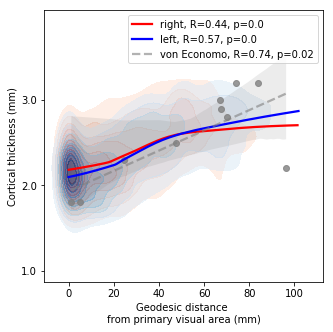

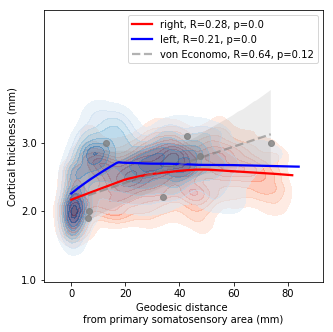

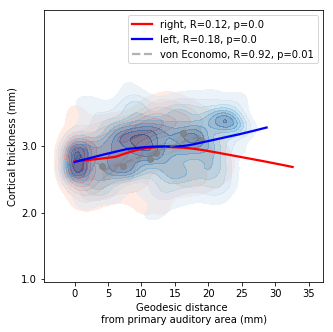

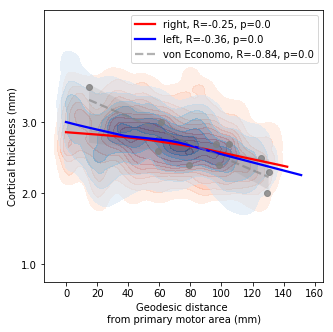

In [4]:
#plotting with von Economo
systems = ['visual','somatosensory','auditory','motor']
hemis=['left','right']
font = {'family' : 'sans-serif',
        'style':'normal',
        'size'   : 30}

ve_thickness=pd.read_excel('/data1/users/kwagstyl/bigbrain/NeuralNetworks/von_economo/Thickness_table.xlsx')
tissue='crown_min'
ve_parcellation=np.loadtxt('/data1/users/kwagstyl/bigbrain/NeuralNetworks/von_economo/lh.economo.label.rsled.txt').astype(int)

for system in systems:
    print(system)
    TotalThickness={}
    regions={}
    distances={}
    tear_mask={}
    archi_mask={}
    for k,hemi in enumerate(hemis):
        TotalThickness[hemi]=np.loadtxt(os.path.join(rootdir,'thickness_'+hemi+'_total.txt'))[:163842]
        regions[hemi]=np.loadtxt(os.path.join(geodesicdir,system+'_regions_'+hemi+'.txt')).astype(bool)[:163842]
        distances[hemi]=np.loadtxt(os.path.join(geodesicdir,system+'_geodesic_distances_'+hemi+'.txt'))[:163842]
        tear_mask[hemi]=np.loadtxt(os.path.join(geodesicdir,'tear_mask_'+hemi+'.txt')).astype(bool)[:163842]
        archi_mask[hemi]=np.loadtxt(os.path.join(surfdir,'archi_'+hemi+'.txt')).astype(bool)[:163842]
        #mask archicortex
        regions[hemi]=np.logical_and(regions[hemi],1-archi_mask[hemi])
        regions[hemi]=np.logical_and(regions[hemi],1-tear_mask[hemi])
        
    #only including one hemisphere for von economo
    ve_regions = np.loadtxt(os.path.join(geodesicdir,system+'_regions_left.txt')).astype(bool)[:163842]
    ve_distances=np.loadtxt(os.path.join(geodesicdir,system+'_geodesic_distances_left.txt'))[:163842]
    rois=np.unique(ve_parcellation[ve_regions])
    #filter frontal from rois for somatosensory von economo due to minor misalignments
    
        
    ve_dist_sys=[]
    ve_thick_sys=[]
    for roi in rois:
        if system=='somatosensory' and ve_thickness.loc[roi,'area_name'] == 'FA' or ve_thickness.loc[roi,'area_name'] == 'FB':
            pass
        elif system =='motor' and ve_thickness.loc[roi,'area_name'] == 'PA':
            pass
        elif system =='auditory' and ve_thickness.loc[roi,'area_name'] == 'IB':
            pass
        elif ve_thickness.loc[roi,tissue]>0 and 'L' not in ve_thickness.loc[roi,'area_name']:
            #print(ve_thickness.loc[roi,'area_name'])
            ve_dist_sys.append(np.mean(ve_distances[np.logical_and(ve_parcellation==roi,ve_regions)]))
            ve_thick_sys.append(ve_thickness.loc[roi,tissue])
    
    plt.figure(figsize=(5,5))
    plot_kde_hemis_plus_ve(distances['right'][regions['right']],TotalThickness['right'][regions['right']],
                   distances['left'][regions['left']],TotalThickness['left'][regions['left']],
                   ve_dist_sys, ve_thick_sys,
                   system)
    
    plt.savefig(os.path.join(figdir,system+'total_thickness_both_hemis_plus_ve.pdf'),bbox_inches='tight')

In [5]:
# systems = ['visual','somatosensory','auditory','motor']
# hemis=['left','right']
# for system in systems:
#     TotalThickness={}
#     regions={}
#     distances={}
#     tear_mask={}
#     archi_mask={}
#     for k,hemi in enumerate(hemis):
#         TotalThickness[hemi]=np.loadtxt(os.path.join(rootdir,'thickness_'+hemi+'_total.txt'))[:163842]
#         regions[hemi]=np.loadtxt(os.path.join(geodesicdir,system+'_regions_'+hemi+'.txt')).astype(bool)[:163842]
#         distances[hemi]=np.loadtxt(os.path.join(geodesicdir,system+'_geodesic_distances_'+hemi+'.txt'))[:163842]
#         tear_mask[hemi]=np.loadtxt(os.path.join(geodesicdir,'tear_mask_'+hemi+'.txt')).astype(bool)[:163842]
#         archi_mask[hemi]=np.loadtxt(os.path.join(surfdir,'archi_'+hemi+'.txt')).astype(bool)[:163842]
#         #mask archicortex
#         regions[hemi]=np.logical_and(regions[hemi],1-archi_mask[hemi])
#         regions[hemi]=np.logical_and(regions[hemi],1-tear_mask[hemi])
   

#     plt.figure(figsize=(7,7))
#     plot_kde_hemis(distances['right'][regions['right']],TotalThickness['right'][regions['right']],
#                    distances['left'][regions['left']],TotalThickness['left'][regions['left']],
#                    system)
    
#     plt.savefig(os.path.join(figdir,system+'total_thickness_both_hemis.pdf'),bbox_inches='tight')

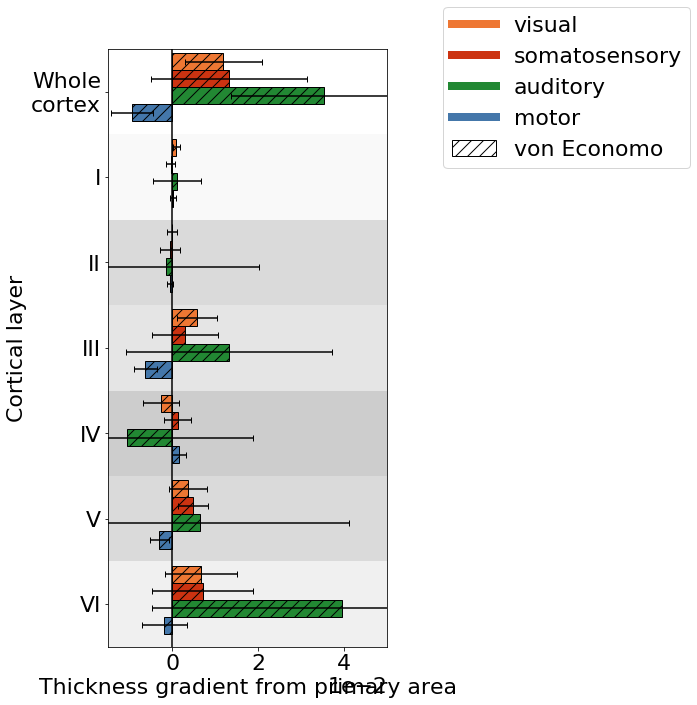

In [6]:
#von Economo gradients
import matplotlib
font = {'family' : 'sans-serif',
        'style':'normal',
        'size'   : 22}

matplotlib.rc('font', **font)
def plot_gradients_stick_ve(Thickness,distances,shift,color='blue',system='visual',normalise=False, hatch=False):
    """plot gradients with c.i.s
    input geodesic distances, layer thicknesses, region to include."""
    beta=np.zeros((6,3))
    for i in range(6):
        if normalise==True:
            y=Thickness["layer{0}".format(i+1)]/Thickness['total']
        else:
            y=Thickness["layer{0}".format(i+1)]
        x=distances
        #g=plot_kde(y,x)
        #R, P = pearsonr(geodist[regions],Thickness["layer{0}".format(i+1)][regions])
        beta[i,:3] = beta_confidence_interval(y,x)
    plt.barh(np.arange(6)+1+shift,beta[:,0],height=0.2,color=color,edgecolor = 'black',
            xerr=beta[:,1]-beta[:,0],capsize=3, label=system,hatch=hatch)
    

systems = ['visual','somatosensory','auditory','motor']
colourmaps = ['Greens','Oranges','Reds','Blues', ]
barWidth = 0.3
colors = [
'#ee7733',
'#cc3311',
'#228833','#4477aa']
include_total=True
plt.figure(figsize=(5,11))
hemis=['right', 'left']
patterns = ['//', '\\\\']
from matplotlib.patches import Patch
from matplotlib.lines import Line2D


legend_elements = [Line2D([0], [0], color=colors[0], lw=8, label=systems[0]),
                   Line2D([0], [0], color=colors[1], lw=8, label=systems[1]),
                   Line2D([0], [0], color=colors[2], lw=8, label=systems[2]),
                   Line2D([0], [0], color=colors[3], lw=8, label=systems[3]),
                   Patch(facecolor='white',hatch=patterns[0], edgecolor='black',
                         label='von Economo'),
                   ]
gray_colours=[50,200,150,250,200,100]
cmap=plt.get_cmap('Greys')

for n in range(6):
        plt.axhspan(n+0.5,n+1.5, color=cmap(gray_colours[n]), alpha=0.2, linewidth=0)
         
ve_thickness=pd.read_excel('/data1/users/kwagstyl/bigbrain/NeuralNetworks/von_economo/Thickness_table.xlsx')
ve_parcellation=np.loadtxt('/data1/users/kwagstyl/bigbrain/NeuralNetworks/von_economo/lh.economo.label.rsled.txt').astype(int)
for k,system in enumerate(systems):

    ve_regions = np.loadtxt(os.path.join(geodesicdir,system+'_regions_left.txt')).astype(bool)[:163842]
    ve_distances=np.loadtxt(os.path.join(geodesicdir,system+'_geodesic_distances_left.txt'))[:163842]
    rois=np.unique(ve_parcellation[ve_regions])
    h=0
    ve_dist_sys=[]
    ve_thick_sys={}
    ve_thick_sys["total"]=[]
    for roi in rois:
        #filter bad ROIs
        if system=='somatosensory' and ve_thickness.loc[roi,'area_name'] == 'FA' or ve_thickness.loc[roi,'area_name'] == 'FB':
            pass
        elif system =='motor' and ve_thickness.loc[roi,'area_name'] == 'PA':
            pass
        elif system =='auditory' and ve_thickness.loc[roi,'area_name'] == 'IB':
            pass
        elif ve_thickness.loc[roi,'wall']>0 and 'L' not in ve_thickness.loc[roi,'area_name']:
            ve_dist_sys.append(np.mean(ve_distances[np.logical_and(ve_parcellation==roi,ve_regions)]))
            ve_thick_sys['total'].append(ve_thickness.loc[roi,'crown_min'])
            
            for n in range(6):
                if not "layer{0}".format(n+1) in ve_thick_sys.keys():
                    ve_thick_sys["layer{0}".format(n+1)]=[]
                tissue='ve_'+str(n+1)
                ve_thick_sys["layer{0}".format(n+1)].append(ve_thickness.loc[roi,tissue])


    plot_gradients_stick_ve(ve_thick_sys,ve_dist_sys,shift=k/5.+h/10.-0.35,color=colors[k] ,system=system, hatch=patterns[h])
    plt.yticks(np.arange(7)+1,['I','II','III','IV','V','VI'])
    plt.ylim([0.7,6.8])
    if include_total:
        y=ve_thick_sys["total"] #[:1000]
        x=ve_dist_sys #[:1000]
        beta = beta_confidence_interval(y,x)
        plt.barh(k/5.+h/10.-0.35,beta[0],height=0.2,color=colors[k],edgecolor = 'black',
            xerr=beta[1]-beta[0],capsize=3,hatch=patterns[h])
        plt.yticks(np.arange(7),['Whole\ncortex','I','II','III','IV','V','VI'])
        plt.ylim([-0.5,6.5])


plt.ylabel('Cortical layer')
plt.xlabel('Thickness gradient from primary area')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.plot([0,0],[-0.8,6.5],color='k')
plt.legend(handles=legend_elements,loc=(1.201,0.8))
plt.xlim([-0.015,0.05])
#insert gray bars

plt.gca().invert_yaxis()
plt.savefig(os.path.join(figdir,'all_systems_gradients_ve.eps'),bbox_inches='tight')

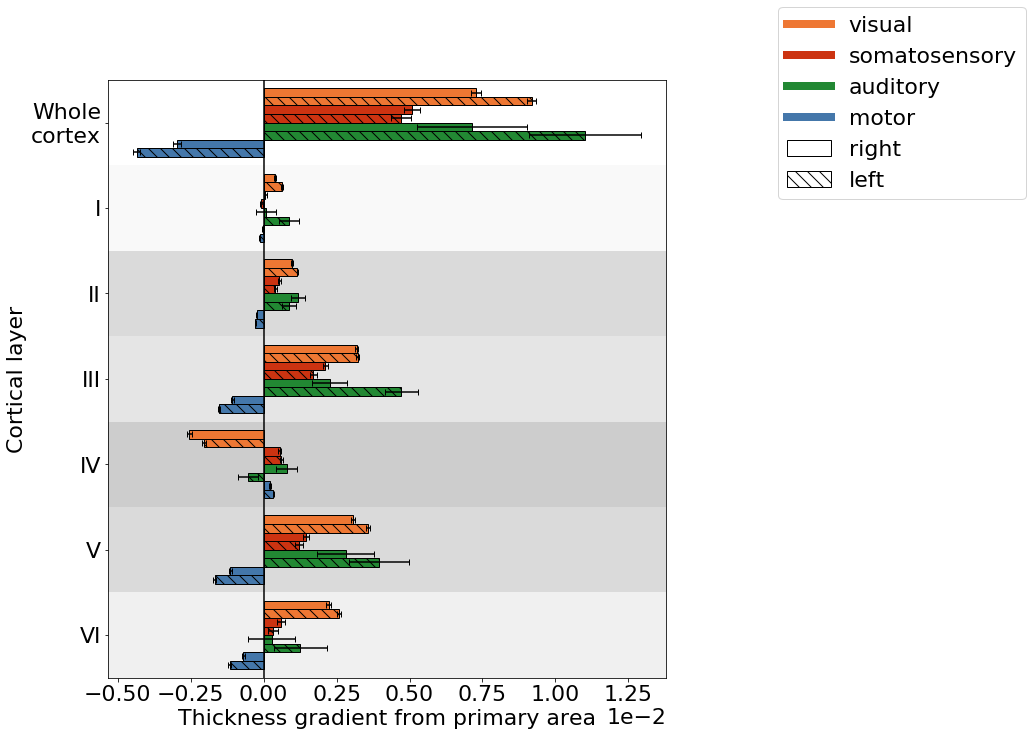

In [7]:
import matplotlib
font = {'family' : 'sans-serif',
        'style':'normal',
        'size'   : 22}

matplotlib.rc('font', **font)
def plot_gradients_stick(Thickness,distances,regions,shift,color='blue',system=system,normalise=False, hatch=False):
    """plot gradients with c.i.s
    input geodesic distances, layer thicknesses, region to include."""
    beta=np.zeros((6,3))
    for i in range(6):
        if normalise==True:
            y=Thickness["layer{0}".format(i+1)][regions]/np.mean(Thickness["layer{0}".format(i+1)][regions])
        else:
            y=Thickness["layer{0}".format(i+1)][regions]
        x=distances[regions]
        #g=plot_kde(y,x)
        #R, P = pearsonr(geodist[regions],Thickness["layer{0}".format(i+1)][regions])
        beta[i,:3] = beta_confidence_interval(y,x)
    plt.barh(np.arange(6)+1+shift,beta[:,0],height=0.1,color=color,edgecolor = 'black',
            xerr=beta[:,1]-beta[:,0],capsize=3, label=system,hatch=hatch)
    

systems = ['visual','somatosensory','auditory','motor']
colourmaps = ['Greens','Oranges','Reds','Blues', ]
barWidth = 0.3
colors = [
'#ee7733',
'#cc3311',
'#228833','#4477aa']
include_total=True
plt.figure(figsize=(10,11))
hemis=['right', 'left']
patterns = ['', '\\\\']
from matplotlib.patches import Patch
from matplotlib.lines import Line2D


legend_elements = [Line2D([0], [0], color=colors[0], lw=8, label=systems[0]),
                   Line2D([0], [0], color=colors[1], lw=8, label=systems[1]),
                   Line2D([0], [0], color=colors[2], lw=8, label=systems[2]),
                   Line2D([0], [0], color=colors[3], lw=8, label=systems[3]),
                   Patch(facecolor='white',hatch=patterns[0], edgecolor='black',
                         label=hemis[0]),
                   Patch(facecolor='white',hatch=patterns[1], edgecolor='black',
                         label=hemis[1])]
gray_colours=[50,200,150,250,200,100]
cmap=plt.get_cmap('Greys')
for n in range(6):
    plt.axhspan(n+0.5,n+1.5, color=cmap(gray_colours[n]), alpha=0.2, linewidth=0)

for h,hemic in enumerate(hemis):
    TotalThickness=np.loadtxt(os.path.join(rootdir,'thickness_'+hemic+'_total.txt'))[:163842]
    Thickness={}
    for n in range(6):
        Thickness["layer{0}".format(n+1)]=np.loadtxt(os.path.join(rootdir,'thickness_'+hemic+'_layer'+str(n+1)+'.txt'))[:163842]


    for k,system in enumerate(systems):
        regions=np.loadtxt(os.path.join(geodesicdir,system+'_regions_'+hemic+'.txt')).astype(bool)[:163842]
        archi_mask=np.loadtxt(os.path.join(surfdir,'archi_'+hemic+'.txt')).astype(bool)[:163842]
        regions=np.logical_and(regions,1-archi_mask)
        mask=np.loadtxt(os.path.join(geodesicdir,'tear_mask_'+hemic+'.txt')).astype(bool)[:163842]
        distances=np.loadtxt(os.path.join(geodesicdir,system+'_geodesic_distances_'+hemic+'.txt'))[:163842]
        regions=np.logical_and(regions,1-mask)
        #if system == 'auditory' :
        #    regions=np.logical_and(regions,1-mask)

         #   regions = np.logical_and(distances <30,regions)

        #elif  system == 'somatosensory':
         #   regions = np.logical_and(distances <51,regions)



        #plt.bar(r1, bars1, width = barWidth, color = 'blue', edgecolor = 'black', yerr=yer1, capsize=7, label=system)
        plot_gradients_stick(Thickness,distances,regions,shift=k/5.+h/10.-0.35,color=colors[k] ,system=system, hatch=patterns[h])
        plt.yticks(np.arange(7)+1,['I','II','III','IV','V','VI'])
        plt.ylim([0.7,6.8])
        if include_total:
            y=TotalThickness #[:1000]
            x=distances #[:1000]
            beta = beta_confidence_interval(y[regions],x[regions])
            plt.barh(k/5.+h/10.-0.35,beta[0],height=0.1,color=colors[k],edgecolor = 'black',
                xerr=beta[1]-beta[0],capsize=3,hatch=patterns[h])
            plt.yticks(np.arange(7),['Whole\ncortex','I','II','III','IV','V','VI'])
            plt.ylim([-0.5,6.5])

plt.ylabel('Cortical layer')
plt.xlabel('Thickness gradient from primary area')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.plot([0,0],[-0.8,6.5],color='k')
plt.legend(handles=legend_elements,loc=(1.201,0.8))

#insert gray bars

plt.gca().invert_yaxis()
plt.savefig(os.path.join(figdir,'all_systems_gradients.eps'),bbox_inches='tight')

In [32]:
betas={}
for h,hemi in enumerate(hemis):
    betas[hemi]={}
    TotalThickness=np.loadtxt(os.path.join(rootdir,'thickness_'+hemi+'_layer3.txt'))[:163482]
    for k,system in enumerate(systems):
        regions=np.loadtxt(os.path.join(geodesicdir,system+'_regions_'+hemi+'.txt')).astype(bool)[:163482]
        #regions=np.where(regions==1)[0]
        distances=np.loadtxt(os.path.join(geodesicdir,system+'_geodesic_distances_'+hemi+'.txt'))[:163482]
        #Thickness=np.loadtxt(os.path.join(rootdir,'thickness_'+hemic+'_layer'+str(k+1)+'.txt'))[:163482]
        betalist=[]
        for w in np.arange(np.max(distances[regions])-10):
            window=np.logical_and(regions, np.logical_and(distances>=w,distances <w+10))
            beta = beta_confidence_interval(TotalThickness[window],distances[window])
            betalist.append(beta[0])
        betas[hemi][system]=betalist

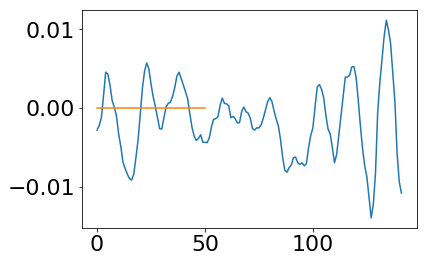

In [39]:
systems = ['motor','visual','somatosensory','auditory']
for system in systems:
    regions=np.loadtxt(os.path.join(geodesicdir,system+'_regions_'+hemic+'.txt')).astype(bool)[:163842]
    #regions=np.where(regions==1)[0]
    distances=np.loadtxt(os.path.join(geodesicdir,system+'_geodesic_distances_'+hemic+'.txt'))[:163842]
    #if system == 'auditory':
    #    regions = np.logical_and(distances <26, regions)
    plt.figure()
    plot_kde(TotalThickness,distances,regions)
    #plt.savefig(system+'total_thickness.pdf',bbox_inches='tight')
    plt.figure()
    stacked_plot(Thickness,distances, regions,n_bins=30, smoothing = 5)
    plt.title(system)
#plt.savefig(os.path.join(figdir,system+'stacked_layers.pdf'),bbox_inches='tight')
   # plt.figure()
   # plot_gradients(Thickness,distances,regions)
   # plt.title(system)
   # plt.savefig(system+'layer_gradients.pdf',bbox_inches='tight')


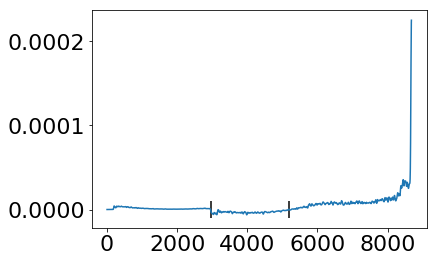

In [107]:
from scipy.ndimage import filters
grad=np.diff(w[:,1])
sm_grad=filters.gaussian_filter1d(grad,sigma=10)
plt.plot(sm_grad)
w[np.where(np.diff(np.sign(sm_grad)))[0],0]
plt.vlines(np.where(np.diff(np.sign(sm_grad))<0)[0],ymin=-0.00001,ymax=0.00001)

array([ 0.      , 16.54272 , 24.600995, 24.694997, 24.883611])